In [1]:
%load_ext autoreload
%autoreload 2
import torch as t
import cv2 
import sys
sys.path.append("/data_nfs/je30bery/melanoma_data/model")
from model import EfficientnetWithFinetuning
from data import MelanomaData
from scipy.stats import pearsonr
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
import random 
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange, tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics.cluster import adjusted_rand_score
sys.path.append("../../")
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.getcwd()

'/data_nfs/je30bery/melanoma_data/model/features'

In [2]:
import MAGICAL as mg

In [3]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin']    

In [4]:
base = "/data_nfs"

In [8]:
data = mg.get_data_csv(base)
dl = t.utils.data.DataLoader(MelanomaData(markers, dataset="Melanoma", data=data, mode="val"), batch_size=10) 
data['Ulcerated'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)
data['Secondary'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)
data['Nodular'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)

In [9]:
labels = data["Group"]

In [10]:
def extract_features(model, x):
    model = model.cuda()
    x = x.cuda()
    x = model.features(x)
    x = model.avgpool(x)
    x = model.flatten(x)
    x = model.classifier1(x)    
    return x

In [11]:
try:
    features = np.load("/data_nfs/je30bery/melanoma_data/model/features/features_regressor.npy")
except:
    model = EfficientnetWithFinetuning(indim=len(markers))
    model.load_state_dict(t.load("/data_nfs/je30bery/melanoma_data/model/training/saved_models/model_2023-11-20 16:27:56.558630_f1=0.9260606060606061_acc=0.9166666666666666_11.pt"))
    
    
    model = t.load(os.path.join(base, "je30bery/melanoma_data/model/model_2024-01-30 17:00:25.231567.pt"), map_location="cuda:0")
    model.eval()
    it = iter(dl)
    features = list()
    while True:
        try:
            input_t, label = next(it)
        except StopIteration:
            break
        features.append(extract_features(model, input_t).detach().cpu().numpy())
    features = np.concatenate(features)
    np.save("features_regressor.npy", features)

In [12]:
pca = PCA(2)
features_2d = pca.fit_transform(features)

In [13]:
data["PC1"] = features_2d[:,0]
data["PC2"] = features_2d[:,1]

<Axes: xlabel='PC1', ylabel='PC2'>

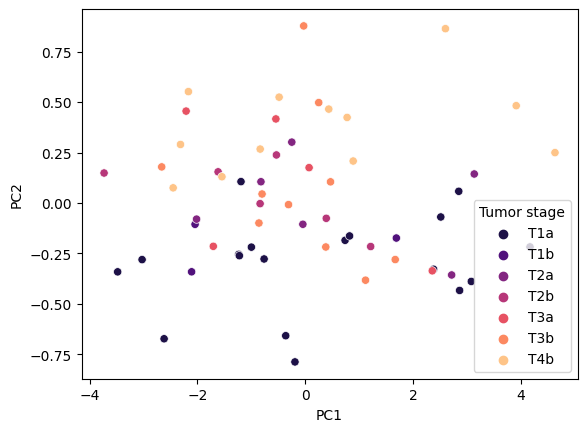

In [14]:
pal = sns.color_palette("magma", 7)
sns.scatterplot(data.sort_values("Tumor stage"), x="PC1", y="PC2", hue="Tumor stage", palette=pal)

In [15]:
result_df = pd.DataFrame()
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    y = kmeans.fit_predict(features)
    for c in ["Imaging year", "Collection year", "Age", 'Sex', 'Ulcerated', 'Secondary', 'Nodular', 'Tumor stage', 'Lymph nodes', 'Distant metastases', 'Stage AJCC']: 
        result_df.loc[k, c] = adjusted_rand_score(y, data[c])

<Axes: >

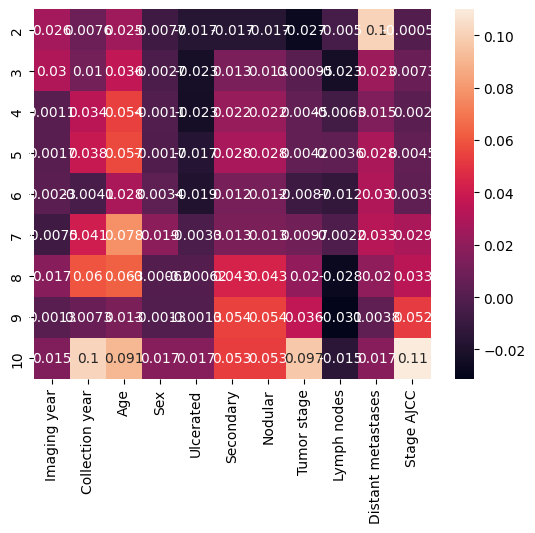

In [16]:
sns.heatmap(result_df, annot=True)

<Axes: xlabel='PC1', ylabel='PC2'>

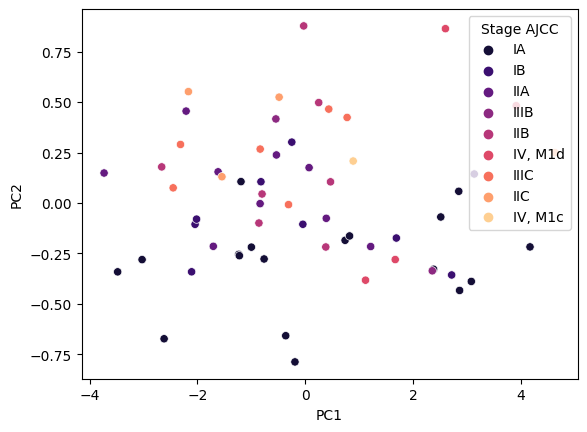

In [18]:
pal = sns.color_palette("magma", 9)
sns.scatterplot(data.sort_values("Tumor stage"), x="PC1", y="PC2", hue="Stage AJCC", palette=pal)